Extract the zip file

In [ ]:
import zipfile 

zip_path = 'cifar10.zip'  
tmp_dir = 'cifar10'      

with zipfile.ZipFile(zip_path, 'r') as zf:
    zf.extractall(tmp_dir)

In [ ]:
import random 
from pathlib import Path 

import torch 
import torch.nn as nn  
import torch.optim as optim  
from torch.utils.data import DataLoader, random_split  # data loading and dataset splitting utilities
from torchvision import datasets, transforms  # vision datasets and transform helpers
from torchvision.transforms import InterpolationMode  # interpolation modes for Resize
from PIL import Image  # Pillow image loading/manipulation
import numpy as np  # numerical arrays and utilities

In [ ]:
DATA_DIR = "cifar10/cifar10"   # root folder where ImageFolder will look for class subfolders
MODEL_PATH = "cifar10_cnn.pth"  # file path where the trained model checkpoint will be saved/loaded

In [ ]:
image_size = 32         # resize all images to (image_size, image_size)
batch_size = 32         # number of samples per training batch
num_workers = 2          # number of subprocesses for data loading (0 on some systems)
learning_rate = 0.0001   # Adam optimizer learning rate
num_epochs = 30          # total training epochs
validation_split = 0.2   # fraction of dataset for testing or validation
seed = 42                # random seed for reproducibility
num_classes = 10         # number of output classes (digits 0-9)

In [ ]:
torch.manual_seed(seed)  # seed PyTorch RNG
random.seed(seed)  # seed Python RNG
np.random.seed(seed)  # seed NumPy RNG

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # choose GPU if available else CPU
print("Device:", device)  # print selected device for confirmation

Device: cuda


In [ ]:
training_transform = transforms.Compose([
    # ---- Data Augmentation (only applied during training) ----
    transforms.RandomRotation(degrees=(-45, 45)),               # randomly rotate images within this degree range
    transforms.RandomAffine(0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10), # apply random translation/scale/shear
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # randomly adjust brightness and contrast

    # ---- Base Preprocessing ----
    transforms.Resize((image_size, image_size), interpolation=InterpolationMode.BILINEAR),  # resize to fixed square
    transforms.ToTensor(),                       # convert PIL image to tensor in [0,1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))         # normalize tensor to approx [-1, 1]
])

validation_transform = transforms.Compose([
    transforms.Resize((image_size, image_size), interpolation=InterpolationMode.BILINEAR),  # resize to fixed square
    transforms.ToTensor(),                       # convert PIL image to tensor in [0,1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # for RGB        # normalize tensor to approx [-1, 1]
])

In [ ]:
dataset = datasets.ImageFolder(root=DATA_DIR)  # create dataset from folder-structured images
num_total = len(dataset)  # total number of image samples
if num_total == 0:
    raise RuntimeError(f"No images found in {DATA_DIR}. Make sure dataset is structured correctly.")  # error out if no images found

print(f"Found {num_total} images across {len(dataset.classes)} classes: {dataset.classes}")  # report counts and class names


Found 50000 images across 10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
val_size = int(validation_split * num_total)  # number of samples for validation
train_size = num_total - val_size  # remaining samples for training
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])  # random split into train/val subsets

train_dataset.dataset.transform = training_transform  # apply training transforms to training set
val_dataset.dataset.transform = validation_transform  # apply validation transforms to validation set

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers)  # DataLoader for training (shuffled)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=num_workers)  # DataLoader for validation (no shuffle)

In [ ]:
class MY_CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()  # initialize parent nn.Module
        # Convolutional blocks
        # Each conv keeps spatial sizes if padding=1 with kernel=3
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # conv: 1->32 channels, preserves spatial size
            nn.ReLU(inplace=True),  # activation
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # conv: 32->64 channels
            nn.ReLU(inplace=True),  # activation
            nn.MaxPool2d(kernel_size=2, stride=2),   # downsample spatial dims by 2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # conv: 64->128
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  # conv: 128->128
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),   # downsample by another factor of 2

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # conv: 128->256
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),   # downsample spatial dims again

            # Make the spatial size fixed before FC using AdaptiveAvgPool (robust)
            # nn.AdaptiveAvgPool2d((4, 4)),            # produce fixed 4x4 spatial output
        )

        # Classifier (fully connected)
        self.classifier = nn.Sequential(
            nn.Flatten(),  # flatten feature map to vector
            nn.Linear(256 * 4 * 4, 512),  # FC layer from flattened features to hidden 512
            nn.ReLU(inplace=True),  # activation
            nn.Dropout(p=0.5),  # dropout to reduce overfitting
            nn.Linear(512, num_classes)  # final linear layer producing class logits
            # Note: no softmax here because CrossEntropyLoss expects raw logits
        )

    def forward(self, x):
        x = self.features(x)  # apply convolutional feature extractor
        x = self.classifier(x)  # apply classifier to get logits
        return x  # return raw logits

In [ ]:
model = MY_CNN(num_classes=num_classes).to(device)  # create model instance and move to device
print(model)  # print model architecture summary

MY_CNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inp

In [ ]:
criterion = nn.CrossEntropyLoss()  # loss function for classification (expects logits)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Adam optimizer for model parameters

In [ ]:
def compute_accuracy(model, data_loader, device):
    model.eval()  # set model to evaluation mode (disables dropout, etc.)
    correct = 0  # running count of correct predictions
    total = 0  # running count of total samples
    running_loss = 0.0  # cumulative loss across samples
    with torch.no_grad():  # disable gradient computation for speed/memory
        for images, labels in data_loader:  # iterate over batches
            images = images.to(device)  # move images to device
            labels = labels.to(device)  # move labels to device
            outputs = model(images)  # forward pass to get logits
            loss = criterion(outputs, labels)  # compute batch loss
            running_loss += loss.item() * images.size(0)  # accumulate total loss (scaled by batch size)
            _, predicted = torch.max(outputs, 1)  # get predicted class indices
            total += labels.size(0)  # add number of samples in batch
            correct += (predicted == labels).sum().item()  # count correct predictions

    avg_loss = running_loss / total  # average loss over dataset
    acc = 100.0 * correct / total  # accuracy percentage
    model.train()  # set model back to training mode
    return avg_loss, acc  # return avg loss and accuracy

In [ ]:
loss_arr = []
acc_arr = []

In [ ]:
best_val_acc = 0.0  # track best validation accuracy
best_epoch = -1  # track epoch of best validation accuracy

for epoch in range(num_epochs):  # loop over epochs
    model.train()  # set model to training mode
    running_loss = 0.0  # cumulative training loss for this epoch
    total_batches = 0  # number of processed batches

    for images, labels in train_loader:  # iterate over training batches
        images = images.to(device)  # move images to device
        labels = labels.to(device)  # move labels to device

        # forward
        outputs = model(images)  # compute logits for current batch
        loss = criterion(outputs, labels)  # compute loss for current batch

        # backward + optimize
        optimizer.zero_grad()  # clear previous gradients
        loss.backward()  # backpropagate to compute gradients
        optimizer.step()  # update model parameters

        running_loss += loss.item()  # accumulate loss value
        total_batches += 1  # increment batch counter

    train_loss = running_loss / total_batches  # average training loss for epoch
    val_loss, val_acc = compute_accuracy(model, val_loader, device)  # evaluate on validation set

    loss_arr.append(train_loss)
    acc_arr.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}]  Train Loss: {train_loss:.4f}  Val Loss: {val_loss:.4f}  Val Acc: {val_acc:.2f}%")  # print epoch metrics

    # Save best model
    if val_acc > best_val_acc:  # if current validation accuracy improved
        best_val_acc = val_acc  # update best accuracy
        best_epoch = epoch + 1  # store epoch number (1-based)
        torch.save({  # save checkpoint dict
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }, MODEL_PATH)  # write checkpoint to MODEL_PATH
        print(f"Saved best model (val_acc={val_acc:.2f}%) to {MODEL_PATH}")  # notify that model was saved

print(f"Training finished. Best val acc: {best_val_acc:.2f}% at epoch {best_epoch}")  # final summary

Epoch [1/50]  Train Loss: 1.6271  Val Loss: 1.2764  Val Acc: 53.49%
Saved best model (val_acc=53.49%) to cifar10_cnn.pth
Epoch [2/50]  Train Loss: 1.2211  Val Loss: 1.0860  Val Acc: 60.75%
Saved best model (val_acc=60.75%) to cifar10_cnn.pth
Epoch [3/50]  Train Loss: 1.0136  Val Loss: 0.9779  Val Acc: 66.12%
Saved best model (val_acc=66.12%) to cifar10_cnn.pth
Epoch [4/50]  Train Loss: 0.8680  Val Loss: 0.8466  Val Acc: 70.07%
Saved best model (val_acc=70.07%) to cifar10_cnn.pth
Epoch [5/50]  Train Loss: 0.7557  Val Loss: 0.7794  Val Acc: 72.75%
Saved best model (val_acc=72.75%) to cifar10_cnn.pth
Epoch [6/50]  Train Loss: 0.6616  Val Loss: 0.7284  Val Acc: 74.83%
Saved best model (val_acc=74.83%) to cifar10_cnn.pth
Epoch [7/50]  Train Loss: 0.5760  Val Loss: 0.7284  Val Acc: 75.70%
Saved best model (val_acc=75.70%) to cifar10_cnn.pth
Epoch [8/50]  Train Loss: 0.4955  Val Loss: 0.6956  Val Acc: 76.53%
Saved best model (val_acc=76.53%) to cifar10_cnn.pth
Epoch [9/50]  Train Loss: 0.4188

Evalutaion

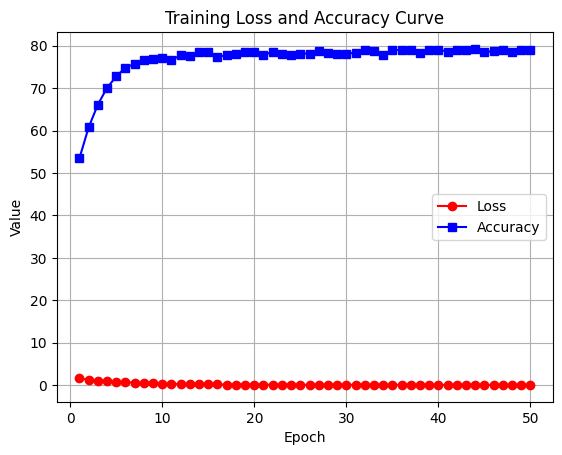

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(loss_arr) + 1)

plt.plot(epochs, loss_arr, 'o-', color='red', label='Loss')       # red line for loss
plt.plot(epochs, acc_arr, 's-', color='blue', label='Accuracy')   # blue line for accuracy

plt.title("Training Loss and Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Make sure model is in evaluation mode
model.eval()

all_preds = []
all_labels = []

# No gradient calculation (faster + uses less memory)
with torch.no_grad():
    for images, labels in val_loader:   # <-- use val_loader if no separate test set
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        # Collect predictions and true labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


from sklearn.metrics import classification_report
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=dataset.classes))

Classification Report:

              precision    recall  f1-score   support

    airplane       0.82      0.84      0.83       998
  automobile       0.87      0.92      0.90       988
        bird       0.69      0.70      0.69      1028
         cat       0.68      0.59      0.63      1007
        deer       0.76      0.75      0.75       986
         dog       0.70      0.72      0.71       981
        frog       0.80      0.85      0.83       979
       horse       0.80      0.82      0.81       971
        ship       0.92      0.84      0.88      1057
       truck       0.85      0.86      0.86      1005

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000



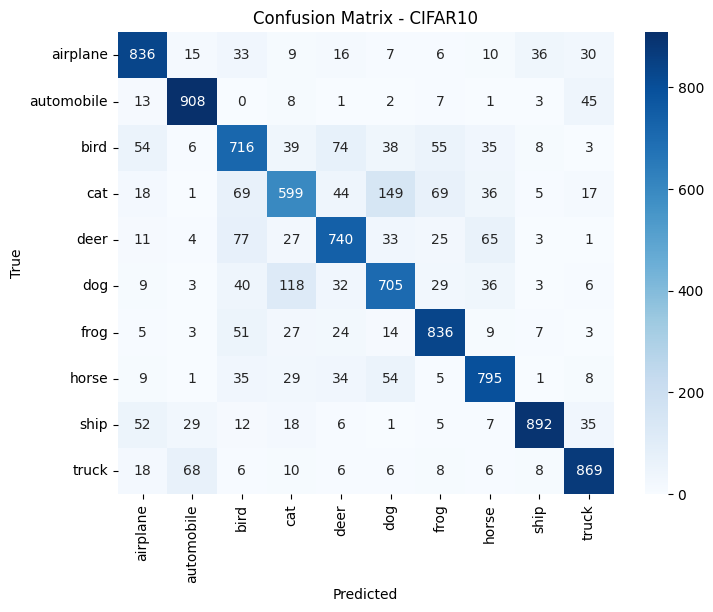

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=dataset.classes,
            yticklabels=dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - CIFAR10")
plt.show()

Load and Predict

In [ ]:
checkpoint = torch.load(MODEL_PATH, map_location=device)  # load saved checkpoint from disk
model.load_state_dict(checkpoint['model_state_dict'])  # load model weights into architecture
model.to(device)  # ensure model is on the correct device
final_val_loss, final_val_acc = compute_accuracy(model, val_loader, device)  # compute final validation metrics
print(f"Final loaded model validation acc: {final_val_acc:.2f}%  loss: {final_val_loss:.4f}")  # print results

Final loaded model validation acc: 79.24%  loss: 1.4047


In [ ]:
softmax = nn.Softmax(dim=1)  # softmax to convert logits to probabilities

def predict_image(img_path_or_pil, model_path=MODEL_PATH, device=device, transform=validation_transform):
    """
    Predict single image. Returns (predicted_label, probs_array)
    """
    # Load model
    chk = torch.load(model_path, map_location=device)  # load checkpoint from disk
    model = MY_CNN(num_classes=num_classes)  # create a fresh model instance
    model.load_state_dict(chk['model_state_dict'])  # populate model weights
    model.to(device)  # move model to device
    model.eval()  # set to evaluation mode

    # Load image (path or PIL)
    if isinstance(img_path_or_pil, (str, Path)):  # if input is a filepath
        img = Image.open(img_path_or_pil)  # open image from path
    elif isinstance(img_path_or_pil, Image.Image):  # if input is already a PIL Image
        img = img_path_or_pil  # use it directly
    else:
        raise ValueError("img_path_or_pil should be path or PIL.Image.Image")  # invalid input type

    # Apply same transforms as training
    x = transform(img).unsqueeze(0)  # apply transforms and add batch dimension
    x = x.to(device)  # move tensor to device

    with torch.no_grad():  # no gradient computation needed
        logits = model(x)  # forward pass to get logits
        probs = softmax(logits).cpu().numpy()[0]  # convert probabilities to NumPy array (first batch element)
        pred = int(np.argmax(probs))  # get index of max probability as predicted label

    return pred, probs  # return predicted label and probability array

In [ ]:
#predict_image("/cifar10/cifar10/ocr_dataset/9/0010_637126265594351740_0713.jpg")  # example: predict a single image by path

In [ ]:
# predict_image('/content/bengali-numbers-1-design-set-vector.jpg')  # example of how to call predict_image with another image (kept commented)